In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from src.utils import get_weeks
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[52:]
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[96:]
week_labels = get_weeks(day_from=20160104, num_weeks=121)[104:]

In [4]:
print(week_labels)

[20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [5]:
%%time
train = pd.DataFrame()
for name in week_labels[:-2]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{name}_SVD_diffscount.feather')])

CPU times: user 1min 23s, sys: 41.1 s, total: 2min 4s
Wall time: 2min 8s


In [6]:
%%time
val = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-2]}_SVD_diffscount.feather')
test = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-1]}_SVD_diffscount.feather')

CPU times: user 800 ms, sys: 568 ms, total: 1.37 s
Wall time: 3.24 s


## Fill nan

In [ ]:
%%time
nan_cols = ['Subsector', 'IndustrySector', 'IndustrySubgroup', 'MarketIssue']
train.fillna({x: '-999' for x in nan_cols}, inplace=True)
val.fillna({x: '-999' for x in nan_cols}, inplace=True)
test.fillna({x: '-999' for x in nan_cols}, inplace=True)

# Preprocessing

In [8]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'
num_cols = [c for c in train.columns \
              if c not in id_cols + cat_cols and c != target_col]

In [9]:
%%time
# Label encode cats
from src.utils import to_cat_codes, apply_cats
to_cat_codes(train, cat_cols)
apply_cats(val, train)
apply_cats(test, train)

for col in cat_cols:
    train[col] = train[col].cat.codes
    val[col] = val[col].cat.codes
    test[col] = test[col].cat.codes

CPU times: user 13.7 s, sys: 2.58 s, total: 16.3 s
Wall time: 16.8 s


In [38]:
for col in cat_cols:
    print(col, train[col].min(), val[col].min(), test[col].min())

BuySell 0 0 0
Sector 0 0 0
Subsector 0 0 0
Region_x 0 0 0
Country 0 0 0
TickerIdx 0 -1 0
Seniority 0 0 0
Currency 0 0 0
ActivityGroup 0 0 0
Region_y 0 0 0
Activity 0 0 0
RiskCaptain 0 0 0
Owner 0 0 0
IndustrySector 0 0 0
IndustrySubgroup 0 0 0
MarketIssue 0 0 0
CouponType 0 0 0


In [10]:
# Val has 1 OOF 
train['TickerIdx'] = train['TickerIdx'] + 1
val['TickerIdx'] = val['TickerIdx'] + 1
test['TickerIdx'] = test['TickerIdx'] + 1

In [11]:
%%time
# Scale conts
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pd.concat([train[num_cols], 
                                         val[num_cols], test[num_cols]]))

MemoryError: 

In [24]:
import pickle
with open(INTERIM/'scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [25]:
def scale_features(df, scaler, num_cols):
    scaled = scaler.transform(df[num_cols])
    for i, col in enumerate(num_cols):
        df[col] = scaled[:,i]

In [26]:
%%time
scale_features(train, scaler, num_cols)
scale_features(val, scaler, num_cols)
scale_features(test, scaler, num_cols)

CPU times: user 6.67 s, sys: 8.05 s, total: 14.7 s
Wall time: 14.7 s


# Model

In [27]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [28]:
cat_szs = [int(train[col].max() + 1) for col in cat_cols]

In [29]:
cat_szs

[2, 5, 35, 3, 86, 3240, 9, 21, 3, 8, 15, 37, 101, 13, 329, 14, 6]

In [30]:
emb_szs = [(c, min(50, (c+1)//2)) for c in cat_szs]

In [31]:
emb_szs

[(2, 1),
 (5, 3),
 (35, 18),
 (3, 2),
 (86, 43),
 (3240, 50),
 (9, 5),
 (21, 11),
 (3, 2),
 (8, 4),
 (15, 8),
 (37, 19),
 (101, 50),
 (13, 7),
 (329, 50),
 (14, 7),
 (6, 3)]

In [74]:
class NeuralNet(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 use_bn=False):
        super().__init__()
        
        self.embs = nn.ModuleList([
            nn.Embedding(c, s) for c,s in emb_szs
        ])
        for emb in self.embs:
            self.emb_init(emb)
            
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont = n_emb, n_cont
        szs = [n_emb + n_cont] + szs
        
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)
        ])
        for o in self.lins: 
            nn.init.kaiming_normal_(o.weight.data)
        
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]
        ])        
            
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)
        
        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([
            nn.Dropout(drop) for drop in drops
        ])
        self.bn = nn.BatchNorm1d(n_cont)
        
        self.use_bn = use_bn
    
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [emb(x_cat[:,i]) for i,emb in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for lin, drop, bn in zip(self.lins, self.drops, self.bns):
            x = F.relu(lin(x))
            if self.use_bn:
                x = bn(x)
            x = drop(x)
        return self.outp(x) # coupled with BCEWithLogitsLoss
    
    def emb_init(self, x):
        # higher init range for low-dimensional embeddings
        x = x.weight.data
        sc = 2 / (x.size(1) + 1)
        x.uniform_(-sc, sc)

In [75]:
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df, cat_cols, num_cols, target_col=None):
        self.cats = df[cat_cols].values.astype(np.int64)
        self.conts = df[num_cols].values.astype(np.float32)
        self.target = df[target_col].values.astype(np.float32) if target_col \
                            else np.zeros((len(df),1)).astype(np.float32)
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.target[idx]]

In [76]:
from torch.utils.data import DataLoader

In [116]:
%%time
train_ds = DataLoader(TabularDataset(train, cat_cols, num_cols, target_col), batch_size=128, shuffle=True)
val_ds = DataLoader(TabularDataset(val, cat_cols, num_cols, target_col), batch_size=128)
test_ds = DataLoader(TabularDataset(test, cat_cols, num_cols), batch_size=128)

CPU times: user 1.76 s, sys: 2.52 s, total: 4.28 s
Wall time: 4.28 s


In [78]:
USE_CUDA = True

In [79]:
# emb_szs = [(2, 1),
#  (5, 3),
#  (36, 18),
#  (3, 2),
#  (86, 43),
#  (3240, 50),
#  (9, 5),
#  (21, 11),
#  (3, 2),
#  (8, 4),
#  (15, 8),
#  (37, 19),
#  (101, 50),
#  (14, 7),
#  (330, 50),
#  (15, 8),
#  (6, 3)]
# num_cols = ['a'] * 51

In [80]:
len(cat_cols), len(num_cols)

(17, 51)

In [81]:
model = NeuralNet(emb_szs, n_cont=len(num_cols), emb_drop=0.04, 
                  out_sz=1, szs=[1000, 500], drops=[0.001, 0.01],
                  use_bn=True)
if USE_CUDA:
    model = model.cuda()

In [82]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [83]:
def train_step(cats, conts, target, model, optimizer, criterion, train=True):
    if train:
        optimizer.zero_grad()
    pred = model(cats, conts)
    loss = criterion(pred.view(-1), target)
    if train:
        loss.backward()
        optimizer.step()
    return loss.item()

In [84]:
def train_model(model, optimizer, criterion, train_loader, val_loader, 
                n_epochs, print_every=800, val_every=4000, USE_CUDA=False):
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_loss, val_loss = 0, 0
        for batch_idx, (cats, conts, target) in enumerate(train_loader):
            cats, conts, target = Variable(cats), Variable(conts), Variable(target)
            if USE_CUDA:
                cats, conts, target = cats.cuda(), conts.cuda(), target.cuda()
            train_loss += train_step(cats, conts, target, model, optimizer, 
                                     criterion, train=True)
            if batch_idx % print_every == 0:
                train_loss /= print_every
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(cats), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), train_loss))
                train_losses.append(train_loss)
                train_loss = 0
            if batch_idx % val_every == 0:
                targets, preds = get_predictions(model, val_ds, USE_CUDA=False)
                val_loss = nn.BCELoss()(targets, preds)
                val_losses.append(val_loss)
                print('Validation Loss: {val_loss:.6f}')
                
        print()
                
    return model, train_losses, val_losses

In [30]:
model.load_state_dict(torch.load(INTERIM/'model_weights.pkl'))

## Train

In [86]:
%%time
model = train_model(model, optimizer, criterion, train_ds, val_ds, 
                    n_epochs=2, USE_CUDA=USE_CUDA)

Train Epoch: 0 [0/8102750 (0%)]	Loss: 0.000944
Train Epoch: 0 [102400/8102750 (1%)]	Loss: 0.165147
Train Epoch: 0 [204800/8102750 (3%)]	Loss: 0.134937
Train Epoch: 0 [307200/8102750 (4%)]	Loss: 0.133561
Train Epoch: 0 [409600/8102750 (5%)]	Loss: 0.133027
Train Epoch: 0 [512000/8102750 (6%)]	Loss: 0.129652
Train Epoch: 0 [614400/8102750 (8%)]	Loss: 0.131317
Train Epoch: 0 [716800/8102750 (9%)]	Loss: 0.130191
Train Epoch: 0 [819200/8102750 (10%)]	Loss: 0.131893
Train Epoch: 0 [921600/8102750 (11%)]	Loss: 0.128500
Train Epoch: 0 [1024000/8102750 (13%)]	Loss: 0.129030
Train Epoch: 0 [1126400/8102750 (14%)]	Loss: 0.131570
Train Epoch: 0 [1228800/8102750 (15%)]	Loss: 0.131791
Train Epoch: 0 [1331200/8102750 (16%)]	Loss: 0.127530
Train Epoch: 0 [1433600/8102750 (18%)]	Loss: 0.128304
Train Epoch: 0 [1536000/8102750 (19%)]	Loss: 0.129086
Train Epoch: 0 [1638400/8102750 (20%)]	Loss: 0.126029
Train Epoch: 0 [1740800/8102750 (21%)]	Loss: 0.127278
Train Epoch: 0 [1843200/8102750 (23%)]	Loss: 0.1267

In [87]:
torch.save(model.state_dict(), INTERIM/'model_weights.pkl')

## Evaluate

In [85]:
import pickle

with open(INTERIM/'train_ds.pkl', 'wb') as f:
    pickle.dump(train_ds, f, pickle.HIGHEST_PROTOCOL)
with open(INTERIM/'val_ds.pkl', 'wb') as f:
    pickle.dump(val_ds, f, pickle.HIGHEST_PROTOCOL)
with open(INTERIM/'test_ds.pkl', 'wb') as f:
    pickle.dump(test_ds, f, pickle.HIGHEST_PROTOCOL)

In [111]:
def get_predictions(model, data_loader, print_every=800, USE_CUDA=False):
    all_targets = []
    all_preds = []
    model.eval()
    for batch_idx, (cats, conts, target) in enumerate(data_loader):
        cats, conts, target = Variable(cats), Variable(conts), Variable(target)
        if USE_CUDA:
            cats, conts, target = cats.cuda(), conts.cuda(), target.cuda()
        preds = model(cats, conts)
        all_targets.extend(target.cpu())
        all_preds.extend(preds.cpu())
        if batch_idx % print_every == 0:
            print('[{}/{} ({:.0f}%)]'.format(
                    batch_idx * len(cats), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader)))
    return [x.item() for x in all_targets], [F.sigmoid(x).item() for x in all_preds]

In [89]:
model = model.cpu()

In [104]:
targets, preds = get_predictions(model, val_ds, USE_CUDA=False)

[0/493590 (0%)]
[102400/493590 (21%)]
[204800/493590 (41%)]
[307200/493590 (62%)]
[409600/493590 (83%)]


In [109]:
from sklearn.metrics import roc_auc_score

In [110]:
roc_auc_score(targets, preds) # validation auc

0.8654110838684123

In [ ]:
targets, preds = get_predictions(model, train_ds, USE_CUDA=False)

[0/8102750 (0%)]
[102400/8102750 (1%)]
[204800/8102750 (3%)]
[307200/8102750 (4%)]
[409600/8102750 (5%)]
[512000/8102750 (6%)]
[614400/8102750 (8%)]
[716800/8102750 (9%)]
[819200/8102750 (10%)]
[921600/8102750 (11%)]
[1024000/8102750 (13%)]
[1126400/8102750 (14%)]
[1228800/8102750 (15%)]
[1331200/8102750 (16%)]
[1433600/8102750 (18%)]
[1536000/8102750 (19%)]
[1638400/8102750 (20%)]
[1740800/8102750 (21%)]
[1843200/8102750 (23%)]
[1945600/8102750 (24%)]
[2048000/8102750 (25%)]
[2150400/8102750 (27%)]
[2252800/8102750 (28%)]


In [ ]:
roc_auc_score(targets, preds)

## Test

In [117]:
targets, preds = get_predictions(model, test_ds, USE_CUDA=False)

[0/484758 (0%)]
[102400/484758 (21%)]
[204800/484758 (42%)]
[307200/484758 (63%)]
[409600/484758 (84%)]


In [118]:
pd.Series(preds).describe()

count    484758.000000
mean          0.020664
std           0.039237
min           0.000000
25%           0.006615
50%           0.013033
75%           0.024082
max           1.000000
dtype: float64

In [120]:
test[target_col] = preds

## Submission

In [121]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [122]:
submission[target_col].describe()

count    484758.000000
mean          0.020664
std           0.039237
min           0.000000
25%           0.006615
50%           0.013033
75%           0.024082
max           1.000000
Name: CustomerInterest, dtype: float64

In [123]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.009377
1,c2cc6cc2a8,0.032916
2,a8e94f6344,0.003766
3,758bae1e35,0.000477
4,02ab378ee8,0.002878


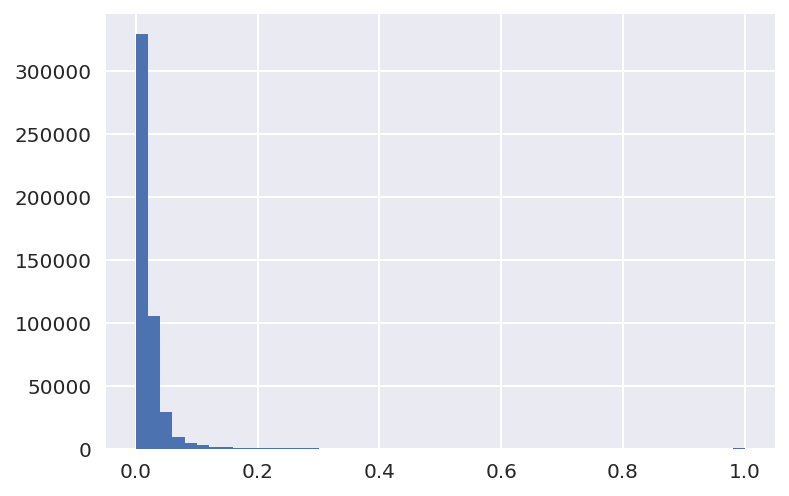

In [124]:
submission[target_col].hist(bins=50)

In [125]:
submission.to_csv(SUBMISSIONS/'RA03-26-neuralnet_2018_SVD_diffscounts.csv', index=False)

## All train

In [14]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [15]:
from src.neuralnet import TabularDataset
from torch.utils.data import DataLoader

In [16]:
%%time
all_train_ds = DataLoader(TabularDataset(pd.concat([train, val]), cat_cols, num_cols, target_col), 
                                                  batch_size=128, shuffle=True)
test_ds = DataLoader(TabularDataset(test, cat_cols, num_cols), batch_size=128)

CPU times: user 4.39 s, sys: 6.38 s, total: 10.8 s
Wall time: 10.8 s


In [18]:
USE_CUDA = True

In [35]:
from src.neuralnet import NeuralNet, train_model

In [32]:
model = NeuralNet(emb_szs, n_cont=len(num_cols), emb_drop=0.04, 
                  szs=[1000, 500, 500], drops=[0.001, 0.01, 0.01],
                  use_bn=True)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [1]:
%%time
model, train_losses, val_losses, val_aucs = train_model(
                                model, optimizer, criterion, 
                                all_train_ds, None, n_epochs=2, 
                                USE_CUDA=USE_CUDA, val_every=10)

In [131]:
%%time
model = train_model(model, optimizer, criterion, all_train_ds, val_ds, 
                    n_epochs=2, USE_CUDA=USE_CUDA)

Train Epoch: 0 [0/8596340 (0%)]	Loss: 0.000955
Train Epoch: 0 [102400/8596340 (1%)]	Loss: 0.164358
Train Epoch: 0 [204800/8596340 (2%)]	Loss: 0.131999
Train Epoch: 0 [307200/8596340 (4%)]	Loss: 0.130099
Train Epoch: 0 [409600/8596340 (5%)]	Loss: 0.133853
Train Epoch: 0 [512000/8596340 (6%)]	Loss: 0.131810
Train Epoch: 0 [614400/8596340 (7%)]	Loss: 0.128595
Train Epoch: 0 [716800/8596340 (8%)]	Loss: 0.129635
Train Epoch: 0 [819200/8596340 (10%)]	Loss: 0.127177
Train Epoch: 0 [921600/8596340 (11%)]	Loss: 0.130097
Train Epoch: 0 [1024000/8596340 (12%)]	Loss: 0.129600
Train Epoch: 0 [1126400/8596340 (13%)]	Loss: 0.128196
Train Epoch: 0 [1228800/8596340 (14%)]	Loss: 0.126975
Train Epoch: 0 [1331200/8596340 (15%)]	Loss: 0.129437
Train Epoch: 0 [1433600/8596340 (17%)]	Loss: 0.129222
Train Epoch: 0 [1536000/8596340 (18%)]	Loss: 0.128111
Train Epoch: 0 [1638400/8596340 (19%)]	Loss: 0.125244
Train Epoch: 0 [1740800/8596340 (20%)]	Loss: 0.127451
Train Epoch: 0 [1843200/8596340 (21%)]	Loss: 0.1291

In [132]:
torch.save(model.state_dict(), INTERIM/'model_weights_alltrain.pkl')

In [133]:
model = model.cpu()

In [134]:
targets, preds = get_predictions(model, test_ds, USE_CUDA=False)

[0/484758 (0%)]
[102400/484758 (21%)]
[204800/484758 (42%)]
[307200/484758 (63%)]
[409600/484758 (84%)]


In [135]:
test[target_col] = preds

## Submission

In [136]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [137]:
submission[target_col].describe()

count    4.847580e+05
mean     2.414028e-02
std      5.604297e-02
min      2.730480e-17
25%      6.091856e-03
50%      1.257137e-02
75%      2.517368e-02
max      1.000000e+00
Name: CustomerInterest, dtype: float64

In [138]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.005362
1,c2cc6cc2a8,0.033340
2,a8e94f6344,0.003676
3,758bae1e35,0.000211
4,02ab378ee8,0.001596


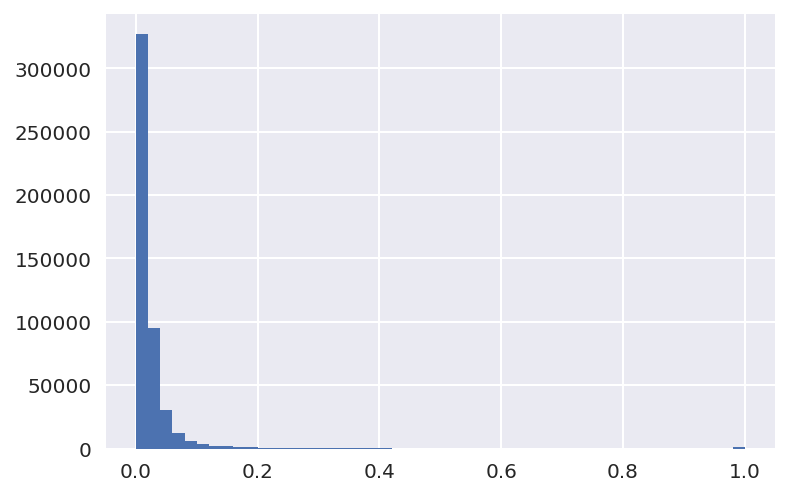

In [139]:
submission[target_col].hist(bins=50)

In [140]:
submission.to_csv(SUBMISSIONS/'RA04-26-neuralnet_alltrain_2018_SVD_diffscounts.csv', index=False)